In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import sacc

## The $C_\ell$ file

This notebook shows how to read and interpret the file containing the power spectra used in *Constraining cosmology with the Gaia-unWISE Quasar Catalog and CMB lensing: structure growth*.

The file is written in "sacc" format, so you will need to install __[sacc](https://sacc.readthedocs.io)__.

Let us start by opening the file!

In [2]:
s = sacc.Sacc.load_fits("cls_quaia_planckPR4_s8.fits")

### Tracer-level information
The sacc file contains information about the three maps used in this analysis: the two quasar overdensity maps, and the *Planck* CMB lensing convergence map.

In particular, you will need to access the redshift distribution of both samples. Let's see how to access that.

['kappa', 'qso0', 'qso1']


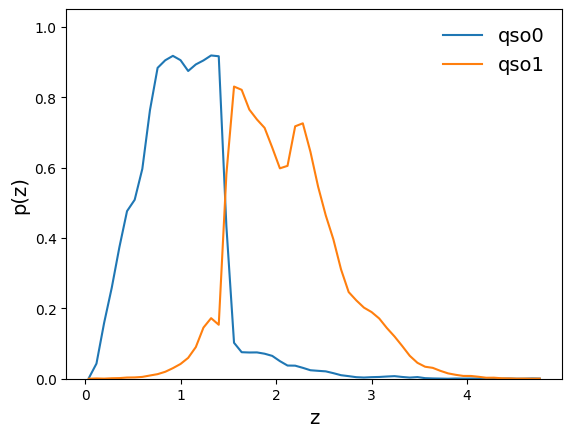

In [3]:
# Let's see what the tracer names are:
print(list(s.tracers.keys()))

# Now let's extract and plot the redshift distributions of the two quasar samples.
for n in ['qso0', 'qso1']:
    t = s.tracers[n]
    plt.plot(t.z, t.nz, '-', label=n)
plt.xlabel('z', fontsize=14)
plt.ylabel('p(z)', fontsize=14)
plt.ylim([0, 1.05])
plt.legend(frameon=False, fontsize=14);

### Reading and plotting the power spectra
The sacc file also contains the power spectra and full covariance matrix of the sample. Let's read and plot the two auto-correlations and the $\kappa$ cross-correlations.

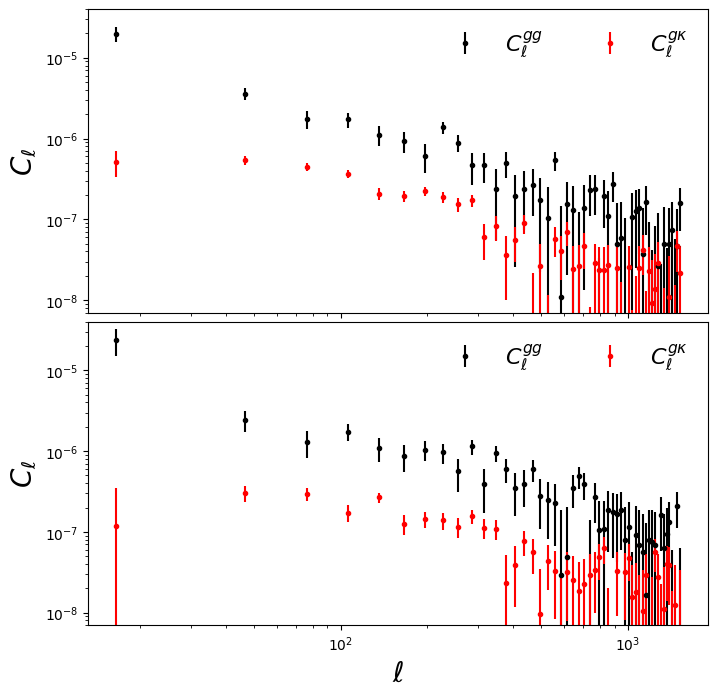

In [4]:
mosaic = """
AA
BB
"""
fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8))
plt.subplots_adjust(hspace=0.03, wspace=0.03)

# First bin
ax = axes['A']
n = 'qso0'
# Auto
l, cl_gg, cov_gg_gg = s.get_ell_cl('cl_00', n, n, return_cov=True)
ax.errorbar(l, cl_gg, yerr=np.sqrt(np.diag(cov_gg_gg)), fmt='k.', label=r'$C_\ell^{gg}$')
# Cross
l, cl_gk, cov_gk_gk = s.get_ell_cl('cl_00', n, 'kappa', return_cov=True)
ax.errorbar(l, cl_gk, yerr=np.sqrt(np.diag(cov_gk_gk)), fmt='r.', label=r'$C_\ell^{g\kappa}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$C_\ell$', fontsize=20)
ax.legend(fontsize=16, ncol=2, frameon=False)
ax.set_ylim([7E-9, 4E-5])


# Second bin
ax = axes['B']
n = 'qso1'
# Auto
l, cl_gg, cov_gg_gg = s.get_ell_cl('cl_00', n, n, return_cov=True)
ax.errorbar(l, cl_gg, yerr=np.sqrt(np.diag(cov_gg_gg)), fmt='k.', label=r'$C_\ell^{gg}$')
# Cross
l, cl_gk, cov_gk_gk = s.get_ell_cl('cl_00', n, 'kappa', return_cov=True)
ax.errorbar(l, cl_gk, yerr=np.sqrt(np.diag(cov_gk_gk)), fmt='r.', label=r'$C_\ell^{g\kappa}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$C_\ell$', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)
ax.legend(fontsize=16, ncol=2, frameon=False)
ax.set_ylim([7E-9, 4E-5]);

### Theoretical predictions
Let's compare these against some theoretical predictions. For simplicity we'll do this only for the first redshift bin. This is only illustrative of how to interpret these data. A proper analysis would need to take into account a number of subtleties that are not described here (e.g. bandpower window convolution, including all cross-covariances in the likelihood, imposing scale cuts, including parameter priors, etc.). This is described in more detail in the paper.

To generate theoretical predictions, we will make use of the Core Cosmology Library, __[CCL](https://github.com/LSSTDESC/CCL)__.

In [26]:
# Let's create a LambdaCDM-like cosmological model
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.67, n_s=0.96, sigma8=0.81)

# Now let's create a galaxy clustering tracer matching the first Quaia bin
# We will give it a constant bias evolution for simplicity. The bias is roughly b_g~2.2.
t_sacc = s.tracers['qso0']
tg = ccl.NumberCountsTracer(cosmo, has_rsd=False,
                            dndz=(t_sacc.z, t_sacc.nz),
                            bias=(t_sacc.z, np.ones_like(t_sacc.z)*2))

# And we'll need a CMB lensing tracer
tk = ccl.CMBLensingTracer(cosmo, z_source=1100.)

# Now we're ready to compute the theoretical predictions:
l, cl_gg, cov_gg_gg = s.get_ell_cl('cl_00', 'qso0', 'qso0', return_cov=True)
clt_gg = ccl.angular_cl(cosmo, tg, tg, l)
l, cl_gk, cov_gk_gk = s.get_ell_cl('cl_00', 'qso0', 'kappa', return_cov=True)
clt_gk = ccl.angular_cl(cosmo, tg, tk, l)

Now let's plot the result!

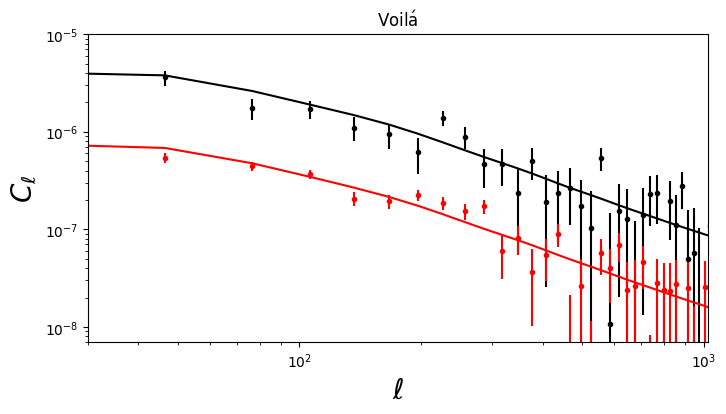

In [35]:
plt.figure(figsize=(8, 4))
ax = plt.gca()
ax.errorbar(l, cl_gg, yerr=np.sqrt(np.diag(cov_gg_gg)), fmt='k.')
ax.plot(l, clt_gg, 'k-')
ax.errorbar(l, cl_gk, yerr=np.sqrt(np.diag(cov_gk_gk)), fmt='r.')
ax.plot(l, clt_gk, 'r-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$C_\ell$', fontsize=20)
ax.set_xlabel(r'$\ell$', fontsize=20)
ax.set_xlim([30, 1024])
ax.set_ylim([7E-9, 1E-5])
ax.set_title(r'${\rm Voil\'a}$');